# Crop Type Classification: CART

Our aim in this notebook is to classify crop type using PlanetScope 4-band Orthotiles. The crop types of particular interest are corn and soybeans.

[CART](http://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) is a decision tree algorithm that has shown great promise for classification of remotely sensed imagery. We will use this algorithm to classify crop type.

In this notebook, we will focus on using the PlanetScope imagery 4 bands as well as NDVI calculation as the features that are fed into the CART algorithm. We will train on one PS Orthotile and validate on another PS Orthotile.

### Outline
1. Identify datasets (PS Orthotiles and gold standard dataset for train and test)
1. Train classifier
1. Test classifier


### Gold Standard Dataset

The [USDA 2016 Crop Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) (CDL) provides a national crop type dataset. This dataset was build using Landsat 8, DMC Deimos-1, and UK 2 satellite imagery ([src](https://www.nass.usda.gov/Research_and_Science/Cropland/sarsfaqs2.php#Section3_17.0)), using supervised classification (decision trees) based on ground truth from the Farm Service Agency (FSA) Common Land Unit (CLU) Program. Since this is a derived dataset, it isn't a ground truth dataset but it is known to be quite accurate so can be used as our gold standard dataset. This dataset is provided as a georegistered raster (geoTIFF).

Since corn and soybeans are the primary crops grown in Iowa, we will focus our analysis in that state. The [metadata](https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia16.htm) provided for the Iowa 2016 CDL indicates that it's accuracy is 96.4% and that corn (categorization code 1) and soybeans (categorization code 5) are indeed the primary crop types in the state.

### Growth Season

[Iowa 1997 statistics](https://usda.mannlib.cornell.edu/usda/nass/planting/uph97.pdf): corn planting ended June 3, harvesting began Sept 17 and soybean planting ended June 17 and harvesting began Sept 21. Therefore, imagery should be limited to between June 3 and Sept 17, 2016.


## Install Dependencies

In [17]:
from collections import namedtuple
import os
from xml.dom import minidom

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

## Identify Datasets

### PS Orthotoile

Get a PS Orthotile that has majority coverage over the grid, is from a SSO satellite, is free from clouds, and was taken between June 3 and Sept 17, 2016.

Using [planet explorer](https://www.planet.com/explorer/), [210879_1558814_2016-07-25_0e16](https://api.planet.com/data/v1/item-types/PSOrthoTile/items/210879_1558814_2016-07-25_0e16/thumb) was identified as a good candidate.

#### Download Scene and Supporting Files

In [18]:
# learn more about PSOrthotile 210879_1558814_2016-07-25_0e16

# !planet data search --item-type PSOrthoTile --string-in id 210879_1558814_2016-07-25_0e16

In [19]:
# Download scene and supporting files to local folder

# !mkdir -p data/cart/210879_1558814_2016-07-25_0e16
# !planet data download --item-type PSOrthoTile --dest data/cart/210879_1558814_2016-07-25_0e16 \
#     --asset-type analytic,analytic_xml,udm --string-in id 210879_1558814_2016-07-25_0e16
# !gdalinfo data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif
# !gdalinfo data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif
# !gdal_translate -outsize 25% 25% \
#     data/cart/210879_1558814_2016-07-25_0e16/210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif \
# !ls -l --block-size=M data/cart/210879_1558814_2016-07-25_0e16

In [20]:
# define data file filenames and ensure they exist
train_folder = os.path.join('data', 'cart', '210879_1558814_2016-07-25_0e16')

train_files = {
    'scene': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic.tif'),
    'metadata': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_metadata.xml'),
    'udm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_DN_udm.tif'),
#     'scene_sm': os.path.join(train_folder, '210879_1558814_2016-07-25_0e16_BGRN_Analytic_sm.tif')
}

for filename in train_files.values():
    assert os.path.isfile(filename)

### 2016 Iowa CDL

Download data for Iowa from [USDA 2016 Crop Data Layer](https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php) (CDL). Filter to corn / soybeans. 

This is achieved by using the [CropScape](https://nassgeodata.gmu.edu/CropScape/) site.

In [21]:
# TODO

## Train Classifier

### PS Orthotile to features

In this section we generate classification features from the 4 bands of the PS Orthotile and NDVI calculated from the Orthotile.

#### Convert UDM to mask

We convert the UDM file to a boolean mask that can be used to generate masked band arrays

In [22]:
def load_udm_mask(udm_filename, window=None):
    udm_array = _read_window(udm_filename, window)
    return _udm_to_mask(udm_array)

def _read_window(filename, window):
    with rasterio.open(filename, 'r') as src:
        return src.read(window=window)
    
def _udm_to_mask(udm_array):
    '''Convert UDM bit-encoded array to boolean mask.
    
    The description for the information encoded in the bits in the UDM is given here:
    https://www.planet.com/docs/spec-sheets/sat-imagery/
    
    Pixels with no issues have all bits set to 0, therefore their values are zero.
    
    We mask all pixels with any issues.
    '''
    return udm_array != 0

udm_mask = load_udm_mask(train_files['udm'], window=((0,1000),(0,1000)))
print(udm_mask.shape)
del udm_mask

(1, 1000, 1000)


#### Load and Mask Bands

We load the orthotile bands (optionally applying a window) and mask them using the udm mask.

In [23]:
NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_masked_bands(scene_filename, udm_filename, window=None):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all.
    """
    bands = load_bands(scene_filename, window=window)
    mask = load_udm_mask(udm_filename, window=window)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

def load_bands(filename, window=None):      
    b, g, r, nir = _read_window(filename, window=window)
    return NamedBands(b=b, g=g, r=r, nir=nir)

def get_mask(bands):
    return bands[0].mask


def check_mask(bands):
    band_mask = get_mask(bands)
    return '{}/{} ({}%) masked'.format(band_mask.sum(), band_mask.size, (100.0*band_mask.sum())/band_mask.size)


print(check_mask(load_masked_bands(train_files['scene'],
                                   train_files['udm'],
                                   window=((500,1500),(500,1500)))))

245766/1000000 (24.5766%) masked


#### Convert to Reflectance

The PSOrthotiles provide the top of atmosphere radiance values for each band. It is preferred to work with top of atmosphere reflectance, as this is more consistent across time. Therefore, we convert each band to reflectance.

In [24]:
# Utility functions: converting an image to reflectance

NamedCoefficients = namedtuple('NamedCoefficients', 'b, g, r, nir')

def read_refl_coefficients(metadata_filename):
    # https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/ndvi/ndvi_planetscope.ipynb
    xmldoc = minidom.parse(metadata_filename)
    nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

    # XML parser refers to bands by numbers 1-4
    coeffs = {}
    for node in nodes:
        bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
        if bn in ['1', '2', '3', '4']:
            i = int(bn)
            value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
            coeffs[i] = float(value)
    return NamedCoefficients(b=coeffs[1],
                             g=coeffs[2],
                             r=coeffs[3],
                             nir=coeffs[4])

def _apply_coeffs(bands, coeffs):
    return NamedBands(*[b.astype(float)*c for b,c in zip(bands, coeffs)])


print(read_refl_coefficients(train_files['metadata']))

NamedCoefficients(b=2.04606999312e-05, g=2.16563842624e-05, r=2.41577463407e-05, nir=3.6441364923e-05)


In [25]:
def load_reflectance_bands(scene_file, udm_file, metadata_file, window=None):
    return _to_reflectance(load_masked_bands(scene_file, udm_file, window=window),
                                metadata_file)

def _to_reflectance(bands, metadata_filename):
    coeffs = read_refl_coefficients(metadata_filename)
    return _apply_coeffs(bands, coeffs)

bands = load_reflectance_bands(train_files['scene'],
                               train_files['udm'],
                               train_files['metadata'],
                               window=((500,1500),(500,1500)))
print([b.mean() for b in bands])
del bands

[0.088216494256910125, 0.083036353501880197, 0.061121440143740512, 0.41378037267261381]


#### Display Image

To ensure everything loaded correctly, we display the image with and without the mask converted to the alpha channel.

In [26]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
    band = np.atleast_3d(bands[0])
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=False):
    """Converts a list of 3 bands to a 3-band rgb, normalized array for display."""  
    assert len(bands) in [1,3]
    all_bands = np.dstack(bands)
    old_min = np.percentile(all_bands, 2)
    old_max = np.percentile(all_bands, 98)

    new_min = 0
    new_max = 1
    scaled = [np.clip(_linear_scale(b.astype(np.double),
                                    old_min, old_max, new_min, new_max),
                      new_min, new_max)
              for b in bands]

    filled = [b.filled(fill_value=new_min) for b in scaled]
    if alpha:
        filled.append(_mask_to_alpha(scaled))

    return np.dstack(filled)

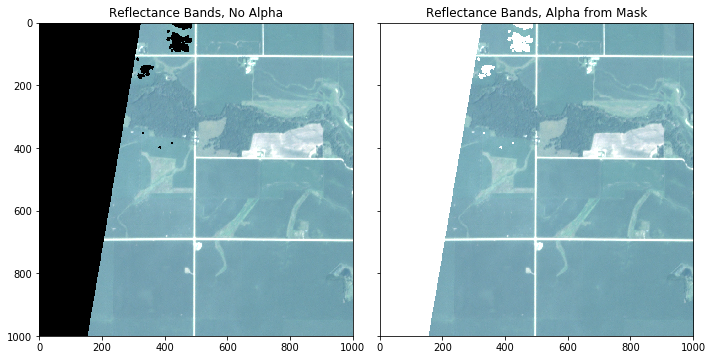

In [27]:
def get_rgb(named_bands):
    '''convenience function to aid in displaying a NamedBands image'''
    return [named_bands.r, named_bands.g, named_bands.b]

def show_bands(bands):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,10))
    for ax in (ax1, ax2):
        ax.set_adjustable('box-forced')

    ax1.imshow(bands_to_display(get_rgb(bands), alpha=False))
    ax1.set_title('Reflectance Bands, No Alpha')

    ax2.imshow(bands_to_display(get_rgb(bands), alpha=True))
    ax2.set_title('Reflectance Bands, Alpha from Mask')
    plt.tight_layout()


refl_bands = load_reflectance_bands(train_files['scene'],
                                    train_files['udm'],
                                    train_files['metadata'],
                                    window=((500,1500),(500,1500)))
show_bands(refl_bands)
del refl_bands

#### Features from Image

We calculate the classification features from the scene and convert them to an array for feeding into the CART classifier.

In [28]:
def calculate_scaled_ndvi(bands):
    # ndvi: (bands.nir.astype(np.float) - bands.r) / (bands.nir + bands.r)
    
    # this is functionally and linearly equivalent but scaled 0-1
    # ref: https://en.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index
    return bands.nir.astype(np.float) / (bands.nir + bands.r)


def to_X(bands):
    """Calculate features from the bands + ndvi, maintaining order and filtering out masked pixels.
    """
    features = bands + (calculate_scaled_ndvi(bands),)
    return np.stack([f.compressed() for f in features], # exclude masked pixels
                     axis=1)

refl_bands = load_reflectance_bands(train_files['scene'],
                                    train_files['udm'],
                                    train_files['metadata'],
                                    window=((500,1500),(500,1500)))
X = to_X(refl_bands)
print(X.shape)
del X
del refl_bands

(754234, 5)


### Gold Standard Dataset to Labels

Right now I just want to test out loading up the classifier so I am going to set the first half of the labels to 0, the 2nd half to 1.

In [29]:
def make_dummy_y():
    # preliminary info for creating dummy y data

    # mask info
    refl_bands = load_reflectance_bands(train_files['scene'],
                                        train_files['udm'],
                                        train_files['metadata'],
                                        window=((500,1500),(500,1500)))
    band_mask = get_mask(refl_bands)
    print(band_mask.shape)

    # y feature number
    X = to_X(refl_bands)
    num_features = X.shape[0]
    del X
    del refl_bands
    
    # making dummy y data

    # name of class with value equal to index
    # aka first entry is name of class with value = 0
    class_names = ['zero', 'one', 'two']

    class_labels = dict((i, n) for i,n in enumerate(class_names))
    print(class_labels)

    y = np.zeros((num_features), dtype=np.uint8)
    y[300000:-1] = 1
    y[600000:-1] = 2
    print(y.shape)
    
    return y, band_mask, class_labels

refl_bands = load_reflectance_bands(train_files['scene'],
                                    train_files['udm'],
                                    train_files['metadata'],
                                    window=((500,1500),(500,1500)))
y, band_mask, class_labels = make_dummy_y()

(1000, 1000)
{0: 'zero', 1: 'one', 2: 'two'}
(754234,)


#### Display Labels as Classified Band

In [30]:
def classified_band_from_y(y, band_mask):
    class_band = np.ma.array(np.zeros(band_mask.shape, dtype=y.dtype),
                             mask=band_mask.copy())
    class_band[~class_band.mask] = y
    return class_band

In [31]:
def imshow_class_band(ax, class_band, class_labels):
    """Show classified band with legend. Alters ax in place."""
    im = ax.imshow(class_band)

    # https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    colors = [im.cmap(im.norm(value))
              for value in class_labels.keys()]
    labels = class_labels.values()

    # https://matplotlib.org/users/legend_guide.html
    # tag: #creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
    patches = [mpatches.Patch(color=c, label=l) for c,l in zip(colors, labels)]
    
    ax.legend(handles=patches, bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.)

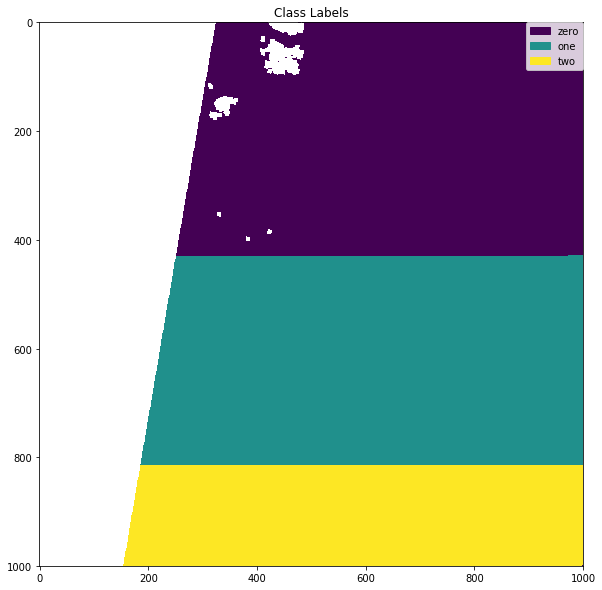

In [32]:
def plot_labels(y, band_mask, class_labels):
    
    class_band = classified_band_from_y(y, band_mask)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    imshow_class_band(ax, class_band, class_labels)
    ax.set_title('Class Labels')

plot_labels(y, band_mask, class_labels)

### Train the Classifier

Right now we are just going to train the classifier with a subset of data from the Orthotile (the window we have been working with thus far) and use the dummy label data generated above. The goal is to ensure we can run through training and predicting with the classifier and end up with a classified band that looks like the original in shape/mask and shows the classes as labeled above.

In [33]:
refl_bands = load_reflectance_bands(train_files['scene'],
                                    train_files['udm'],
                                    train_files['metadata'],
                                    window=((500,1500),(500,1500)))
X = to_X(refl_bands)

Unconstrained, decision trees overfit the training data. Therefore, we must constrain the decision tree by setting a hyperparameter. For now, we will just blindly set the `max_depth` hyperparameter. Eventually, it would be ideal to use cross-validation to identify the best hyperparameter values.

In [42]:
clf = DecisionTreeClassifier(random_state=0, max_depth=5)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

If the decision tree is too constrained, only two classes will be predicted. We increase `max_depth` until we have the 3 classes we specified in the dummy data.

In [45]:
y_pred = clf.predict(X)
print(np.unique(y_pred))

[0 1 2]


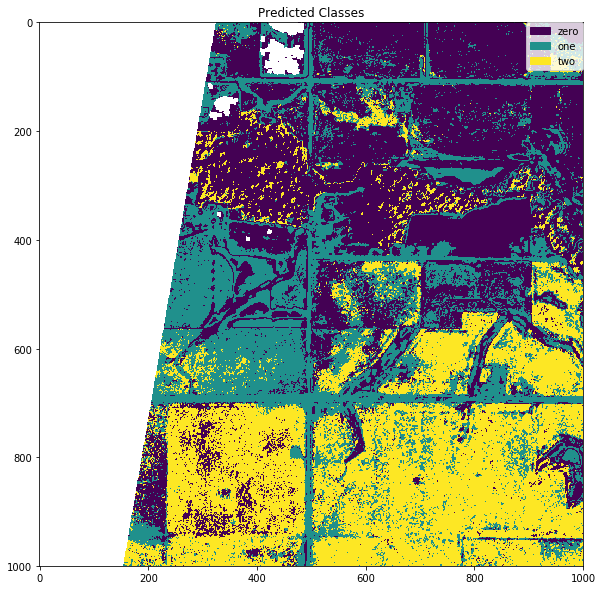

In [46]:
pred_band = classified_band_from_y(y_pred, get_mask(refl_bands))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
imshow_class_band(ax, pred_band, class_labels)
ax.set_title('Predicted Classes')

Alright! This looks promising. As expected, the predicted values do not exactly match the labels (since the labels were created using the y-dimension, but the features fed into the classifier are spectral values, not at all related to the y-dimension).